In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.stats import norm,t
from scipy.optimize import minimize
import statsmodels.api as sm

## Problem1

In [95]:
#Classical Brownian motion
def sim_brownian(pt_1,nsim,sigma):
    r_sim = np.random.normal(0,sigma,size=nsim)
    pt = np.zeros(nsim)
    for i in range(nsim):
         pt[i]=pt_1+r_sim[i]
    print("Expected Mean of Classical Brownian: {}".format(pt_1))
    print("Expected std of Classical Brownian: {}".format(sigma))
    print("Mean of Classical Brownian is {}".format(pt.mean()))
    print("STD of Classical Brownian is {}".format(pt.std()))
    return pt

In [96]:
# Arithmetic return
def sim_arith(pt_1,nsim,sigma):
    r_sim = np.random.normal(0,sigma,size=nsim)
    pt = np.zeros(nsim)
    for i in range(nsim):
         pt[i]=pt_1*(1+r_sim[i])
    print("Expected Mean of Arithmetic return: {}".format(pt_1))
    print("Expected std of Arithmetic return: {}".format(pt_1*sigma))
    print("Mean of Arithmetic return is {}".format(pt.mean()))
    print("STD of Arithmetic return is {}".format(pt.std()))
    return pt

In [97]:
# Log return
def sim_log(pt_1,nsim,sigma):
    r_sim = np.random.normal(0,sigma,size=nsim)
    pt = np.zeros(nsim)
    for i in range(nsim):
         pt[i]=pt_1*math.exp(r_sim[i])
    print("Expected Mean of Log return: {}".format(pt_1*math.exp(sigma*sigma/2)))
    print("Expected std of Log return: {}".format(pt_1*math.sqrt((math.exp(sigma*sigma)-1)*math.exp(sigma*sigma))))
    print("Mean of Log return is {}".format(pt.mean()))
    print("STD of Log return is {}".format(pt.std()))
    return pt

Expected Mean of Classical Brownian: 100
Expected std of Classical Brownian: 0.1
Mean of Classical Brownian is 100.00025592141739
STD of Classical Brownian is 0.10013754071131549
Expected Mean of Arithmetic return: 100
Expected std of Arithmetic return: 10.0
Mean of Arithmetic return is 99.97267952345389
STD of Arithmetic return is 10.141763119363723
Expected Mean of Log return: 100.5012520859401
Expected std of Log return: 10.075302944620395
Mean of Log return is 100.40526933286763
STD of Log return is 10.067925801633969


Text(0.5, 1.0, 'Log Return')

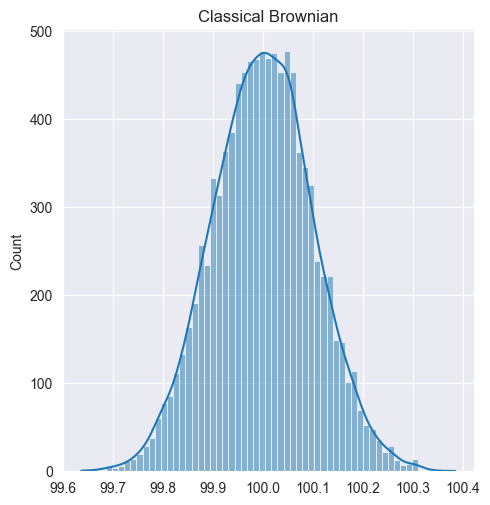

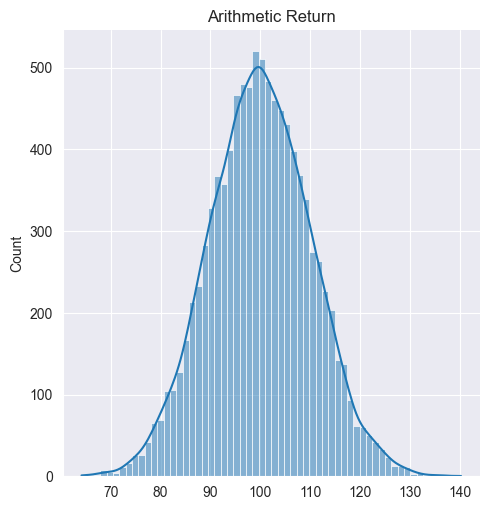

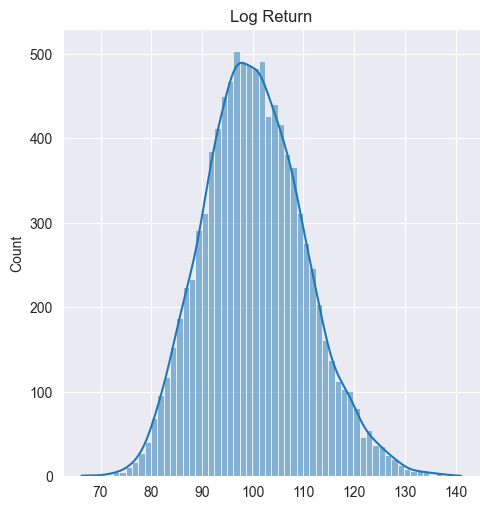

In [99]:
sigma = 0.1
pt_1=100
nsim=10000
psim_b = sim_brownian(pt_1,nsim,sigma)
sns.displot(psim_b,kde=True)
plt.title("Classical Brownian")
psim_a = sim_arith(pt_1,nsim,sigma)
sns.displot(psim_a, kde=True)
plt.title("Arithmetic Return")
psim_l= sim_log(pt_1,nsim,sigma)
sns.displot(psim_l, kde=True)
plt.title("Log Return")

## Problem2

In [4]:
def return_calculate(df,method):
    # Check if datecolumn exists
    if df.columns[0]=='Date':
        ind = df.columns[1:]
        datesig = True
    else:
        ind = df.columns
        datesig = False
    p = df.loc[:,ind]
    n = p.shape[1]
    t = p.shape[0]
    p2 = np.zeros((t-1,n))
    for i in range(t-1):
        for j in range(n):
            p2[i,j]=p.iloc[i+1,j]/p.iloc[i,j]
    # Choose the method
    if method.upper()== "DISCRETE":
        p2 = p2 -1
    elif  method.upper()== "LOG":
        p2 = np.log(p2)
    else:
        raise Exception("Method be either discrete or log")
    # Add DateColumn back to data if datecolumn exists
    out = pd.DataFrame(data=p2,columns=ind)
    if datesig == True:
        out.insert(0,'Date',np.array(df.loc[1:,'Date']))
    return out

In [5]:
# Read in DailyPrices.csv
data = pd.read_csv("DailyPrices.csv")

In [6]:
# Calculate the arithmetic returns
r_a = return_calculate(data,'discrete')

In [7]:
# Series of meta
meta = r_a['META']
# Remove mean
meta_h = meta-meta.mean()

<AxesSubplot: >

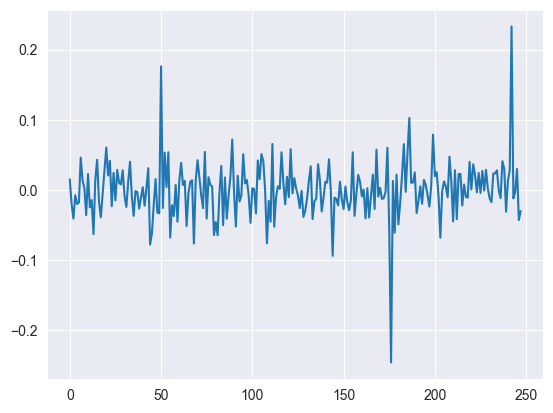

In [21]:
meta_h.plot()

In [8]:
# Plot Var
def plot_var(r,var,method):
    # KDE curve
    d = sns.kdeplot(r)
    # Get x,y axis data of the plot
    x=d.lines[0].get_xydata()[:,0]
    y=d.lines[0].get_xydata()[:,1]
    # Shade area below VaR
    d.fill_between(x,y,where= (x<-var),color="red")
    plt.title(method)
    plt.show()

In [9]:
# VAR using normal distribution
def var_normal(r,alpha=0.05,nsim=10000):
    sigma = r.std()
    rsim = np.random.normal(0,sigma,nsim)
    rsim.sort()
    VaR = -np.quantile(rsim,alpha)
    print("VAR for normal distribution is: {}".format(VaR))
    return rsim, VaR

VAR for normal distribution is: 0.06672395547012276


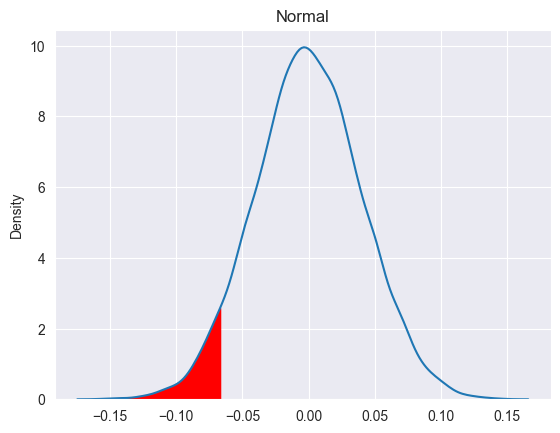

In [10]:
# Calculate VaR for META using Normal
r,v = var_normal(meta_h)
plot_var(r,v,"Normal")

In [11]:
# weights generating function from week3
def weights_gen(lamda,t):
    # Initialize values
    tw = 0
    w = np.zeros(t)
    # calculate weights
    for i in range(t):
        w[i] = (1-lamda)*lamda ** (t-i-1)
        tw += w[i]
    for i in range(t):
        w[i] = w[i]/tw
    return w

In [12]:
# VAR using normal distribution with EW Variance
def var_norm_ew(r,w,alpha=0.05,nsim=10000):
    # mean of r already 0
    sigma = np.sqrt((r*w).T @ r)
    rsim = np.random.normal(0,sigma,nsim)
    rsim.sort()
    VaR = -np.quantile(rsim,alpha)
    print("VAR for normal distribution with exponentially weighted variance is: {}".format(VaR))
    return rsim, VaR

VAR for normal distribution with exponentially weighted variance is: 0.09024193631314063


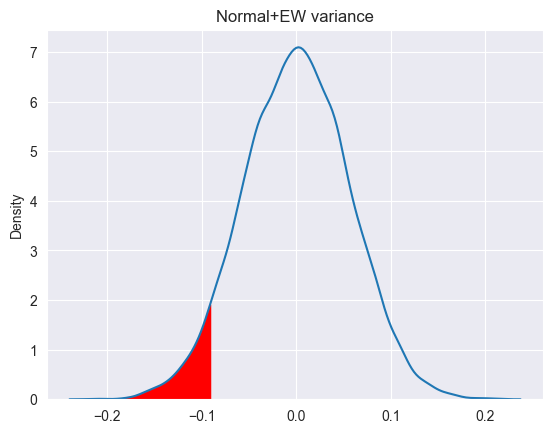

In [13]:
# Calculate EW VaR, lamda =0.94
m = len(meta_h)
w = weights_gen(0.94,m)
r,v = var_norm_ew(meta_h,w)
plot_var(r,v,"Normal+EW variance")

In [14]:
# Get the MLE T function from week2
def t_fit(vals,r):
    nu = vals[0]
    miu = vals[1]
    s = vals[2]
    ll = t.logpdf(r,df=nu,loc=miu,scale=s).sum()
    return -ll

In [15]:
# MLE fitted T distribution
def var_t(r,alpha=0.05,nsim=10000):
    ll_t_res = minimize(t_fit,[5,0,meta_h.std()],args=r,method = 'Nelder-Mead')
    nu,miu,s = ll_t_res.x[0],ll_t_res.x[1],ll_t_res.x[2]
    rsim = t.rvs(df=nu,loc=miu,scale=s,size=nsim)
    rsim.sort()
    VaR = -np.quantile(rsim,alpha)
    print("VAR for MLE fitted T distribution is: {}".format(VaR))
    return rsim, VaR

VAR for MLE fitted T distribution is: 0.05647066333156227


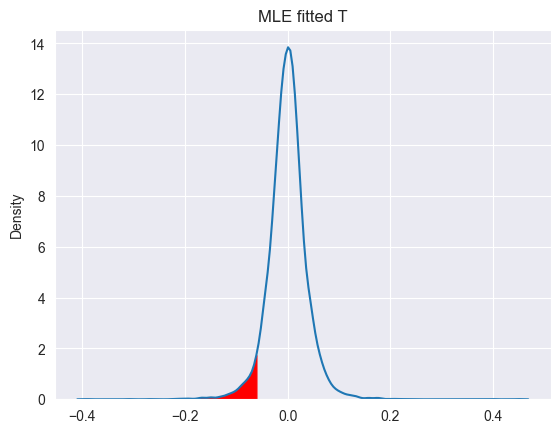

In [16]:
r,v = var_t(meta_h)
plot_var(r,v,"MLE fitted T")

In [17]:
# Fitted AR(1)
def var_ar(r,alpha=0.05,nsim=10000):
    ar1_fit = sm.tsa.arima.ARIMA(r, order=(1, 0, 0))
    con,beta,s= ar1_fit.fit().params[0],ar1_fit.fit().params[1],np.sqrt(ar1_fit.fit().params[2])
    esim = np.random.normal(0,s,nsim)
    rsim = np.zeros(nsim)
    for i in range(nsim):
        rsim[i]=con+r.iloc[-1]*beta+esim[i]
    rsim.sort()
    VaR = -np.quantile(rsim,alpha)
    print("VAR for fitted AR(1) is: {}".format(VaR))
    return rsim, VaR

VAR for fitted AR(1) is: 0.0645666574932234


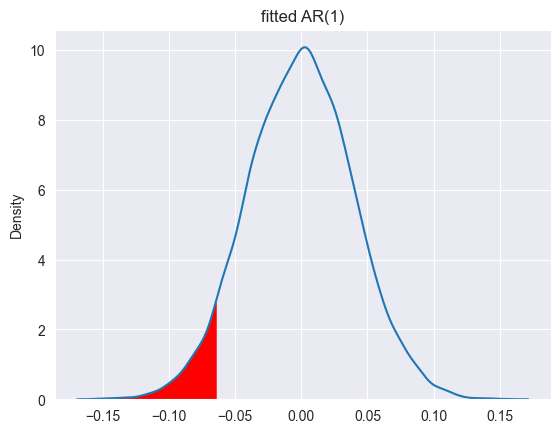

In [18]:
r,v = var_ar(meta_h)
plot_var(r,v,"fitted AR(1)")

In [19]:
# Historic Simulation
def var_his(r,alpha=0.05,nsim=10000):
    rsim = np.random.choice(r,size=nsim)
    rsim.sort()
    VaR = -np.quantile(rsim,alpha)
    print("VAR for Historic Simulation is: {}".format(VaR))
    return rsim, VaR

VAR for Historic Simulation is: 0.05590681367337082


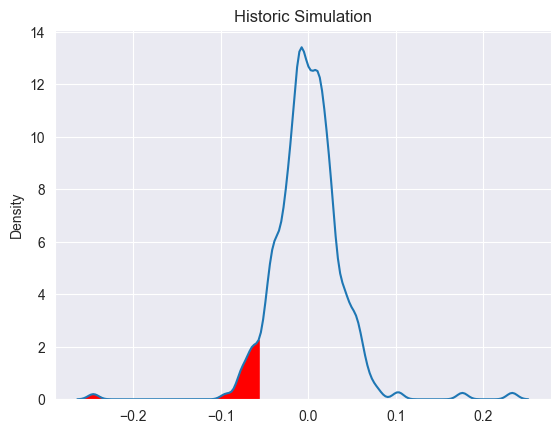

In [20]:
r,v = var_his(meta_h)
plot_var(r,v,"Historic Simulation")

## Problem3

In [22]:
price_data = pd.read_csv("DailyPrices.csv")
port_data = pd.read_csv("portfolio.csv")

In [23]:
# Get the historical prices and holdings of a portfolio
def port_prices(port,stockdata,portdata):
    if port == "All":
        port_prices = stockdata.loc[:,portdata['Stock']]
        port_info = portdata
    else:
        port_info = portdata[port_data['Portfolio']==port]
        port_prices = stockdata.loc[:,port_info['Stock']]
    return port_prices, port_info

In [24]:
# Get the current value and current price of a portfolio
def pv(portprices,portinfo):
    cur_price = portprices.iloc[-1,:]
    cur_value = (cur_price * np.array(portinfo['Holding'])).sum()
    return cur_price,cur_value

In [25]:
# EW covariance calculation from week3
def w_cov(df,lamda):
    n = df.shape[1]
    t = df.shape[0]
    w = weights_gen(lamda,t)
    means = np.array(df.mean())
    xhat = df.copy()
    for i in range(n):
        xhat.iloc[:,i]=xhat.iloc[:,i]-means[i]
    cov = xhat.multiply(w,axis=0).T @ xhat
    return cov

In [26]:
# Delta Normal Var
def delta_norm(port,stockdata,portdata,alpha=0.05):
    his_prices, port_info = port_prices(port,stockdata,portdata)
    cur_prices,cur_value = pv(his_prices, port_info)
    r = return_calculate(his_prices,method="Discrete")
    sigma = w_cov(r,0.94)
    # Number of prices underlying
    n= cur_prices.size
    delta = np.zeros(n)
    # Derivative is 1 for stocks
    for i in range(n):
        delta[i] = port_info.iloc[i,2]*cur_prices[i]/cur_value
    # scaler: sqrt(delta.T * sigma * delta)
    delta = pd.DataFrame(delta,index=sigma.index)
    scaler = np.sqrt(delta.T @ sigma @ delta)
    VaR = -cur_value*norm.ppf(alpha)*scaler
    return VaR.iloc[0,0]

In [27]:
# PCA Simulation from week3
def pca_vecs(cov):
    eigvalues, eigvector = np.linalg.eigh(cov)
    # Sort the eig values and vector
    vals = np.flip(eigvalues)
    vecs = np.flip(eigvector,axis=1)
    # Only use the positive eigen values
    posv_ind = np.where(vals >= 1e-8)[0]
    vals = vals[posv_ind]
    vecs = vecs[:,posv_ind]
    vals = np.real(vals)
    return vals,vecs

def pca_simulate(a,nsim):
    # Use the pca function above
    vals,vecs = pca_vecs(a)
    # If pct is given
    # if pct != None:
    #     vals,vecs = vals_pct(vals,vecs,pct)
    B = vecs @ np.diag(np.sqrt(vals))
    m = vals.size
    r = np.random.normal(size=(m,nsim))
    out = (B @ r).T
    return out

In [31]:
# Monte Carlo Simulation of Returns
def return_sim_mc(port,stockdata,portdata,nsim=10000,alpha=0.05):
    his_prices, port_info = port_prices(port,stockdata,portdata)
    cur_prices,cur_value = pv(his_prices, port_info)
    r = return_calculate(his_prices,method="Discrete")
    r_h = r.sub(r.mean(),axis=1)
    # Remove the mean for returns
    sigma = w_cov(r_h,0.94)
    r_sim = pca_simulate(sigma,nsim)
    # Add back the mean of return for each stock
    r_sim = pd.DataFrame(r_sim,columns=his_prices.columns)
    r_new = r_sim.add(r.mean(),axis=1)
    # Calculate the new prices
    p_new = (r_new+1).mul(cur_prices)
    # Calulate portfolio value for each draw
    port_value = p_new.mul(port_info['Holding'].values).sum(axis=1)
    profit = port_value- cur_value
    profit.to_numpy().sort()
    VaR = -np.quantile(profit,alpha)
    return VaR,profit

In [29]:
# Historical Simulation of Returns
def return_sim_his(port,stockdata,portdata,nsim=10000,alpha=0.05):
    his_prices, port_info = port_prices(port,stockdata,portdata)
    cur_prices,cur_value = pv(his_prices, port_info)
    r = return_calculate(his_prices,method="Discrete")
    # Sample from historical data with replacement
    r_sim = r.sample(nsim,replace=True)
    # Calculate the new prices * return
    p_new = (1+r_sim).mul(cur_prices)
    # Calulate portfolio value for each draw
    port_value = p_new.mul(port_info['Holding'].values).sum(axis=1)
    profit = port_value- cur_value
    profit.to_numpy().sort()
    VaR = -np.quantile(profit,alpha)
    return VaR,profit

VaRs for Protfolio A:
VaR for Delta Normal: 5670.2
VaR for Normal monte carlo: 5605.31
VaR for Historical: 9138.87


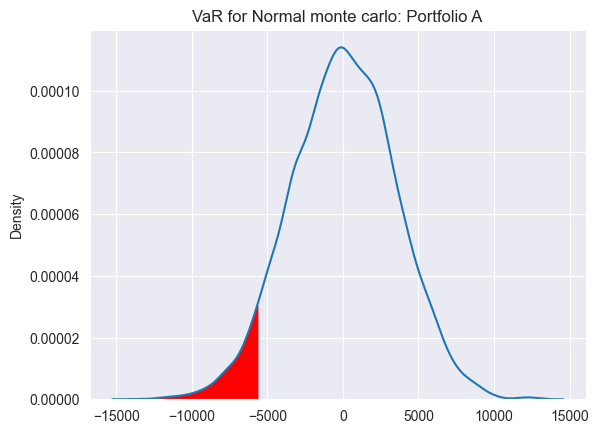

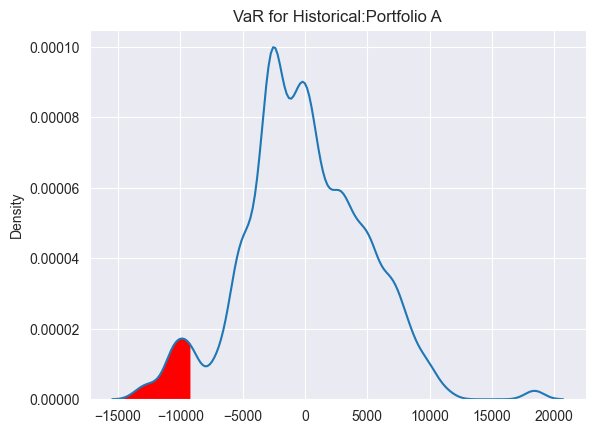

In [33]:
# Compare Results for different methods
print("VaRs for Protfolio A:")
var_a_delta = delta_norm('A',price_data,port_data,alpha=0.05)
print("VaR for Delta Normal: {}".format(round(var_a_delta,2)))
var_a_mc = return_sim_mc('A',price_data,port_data,nsim=10000,alpha=0.05)
print("VaR for Normal monte carlo: {}".format(round(var_a_mc[0],2)))
var_a_his = return_sim_his('A',price_data,port_data,nsim=10000,alpha=0.05)
print("VaR for Historical: {}".format(round(var_a_his[0],2)))
plot_var(var_a_mc[1],var_a_mc[0],"VaR for Normal monte carlo: Portfolio A")
plot_var(var_a_his[1],var_a_his[0],"VaR for Historical:Portfolio A")

VaRs for Protfolio B:
VaR for Delta Normal: 4494.6
VaR for Normal monte carlo: 4337.6
VaR for Historical: 7001.12


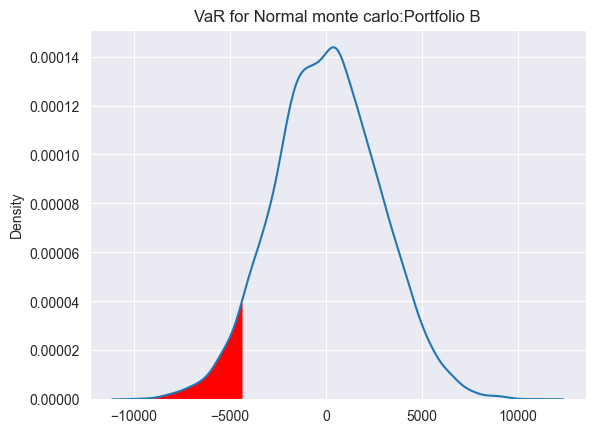

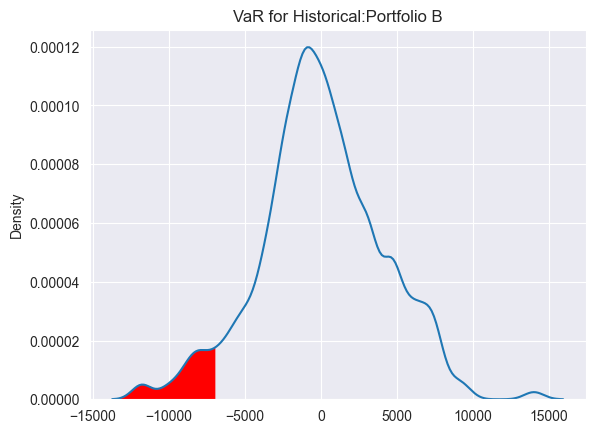

In [34]:
# Compare Results for different methods
print("VaRs for Protfolio B:")
var_b_delta = delta_norm('B',price_data,port_data,alpha=0.05)
print("VaR for Delta Normal: {}".format(round(var_b_delta,2)))
var_b_mc = return_sim_mc('B',price_data,port_data,nsim=10000,alpha=0.05)
print("VaR for Normal monte carlo: {}".format(round(var_b_mc[0],2)))
var_b_his = return_sim_his('B',price_data,port_data,nsim=10000,alpha=0.05)
print("VaR for Historical: {}".format(round(var_b_his[0],2)))
plot_var(var_b_mc[1],var_b_mc[0],"VaR for Normal monte carlo:Portfolio B")
plot_var(var_b_his[1],var_b_his[0],"VaR for Historical:Portfolio B")

VaRs for Protfolio C:
VaR for Delta Normal: 3786.59
VaR for Normal monte carlo: 3769.5
VaR for Historical: 5558.72


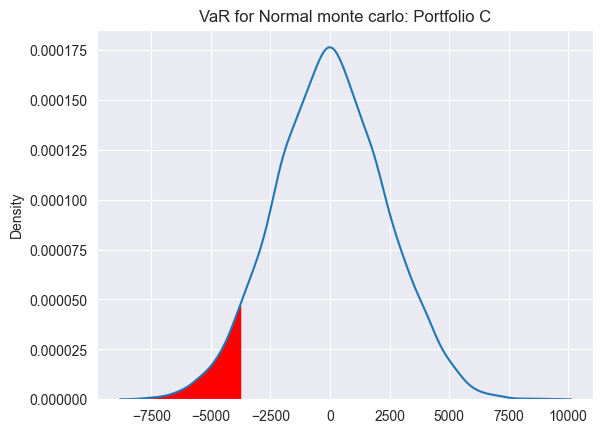

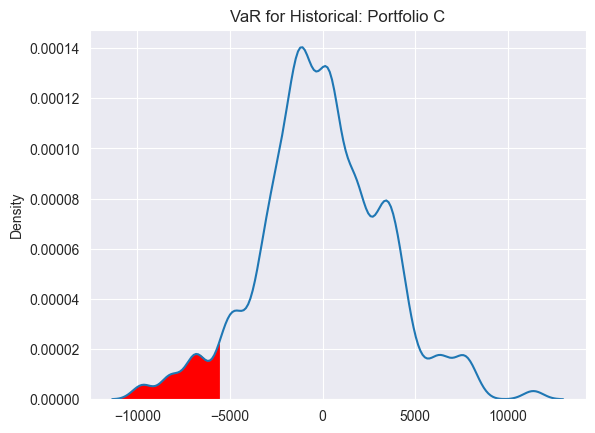

In [35]:
# Compare Results for different methods
print("VaRs for Protfolio C:")
var_c_delta = delta_norm('C',price_data,port_data,alpha=0.05)
print("VaR for Delta Normal: {}".format(round(var_c_delta,2)))
var_c_mc = return_sim_mc('C',price_data,port_data,nsim=10000,alpha=0.05)
print("VaR for Normal monte carlo: {}".format(round(var_c_mc[0],2)))
var_c_his = return_sim_his('C',price_data,port_data,nsim=10000,alpha=0.05)
print("VaR for Historical: {}".format(round(var_c_his[0],2)))
plot_var(var_c_mc[1],var_c_mc[0],"VaR for Normal monte carlo: Portfolio C")
plot_var(var_c_his[1],var_c_his[0],"VaR for Historical: Portfolio C")

VaRs for All:
VaR for Delta Normal: 13577.08
VaR for Normal monte carlo: 13304.87
VaR for Historical: 20564.36


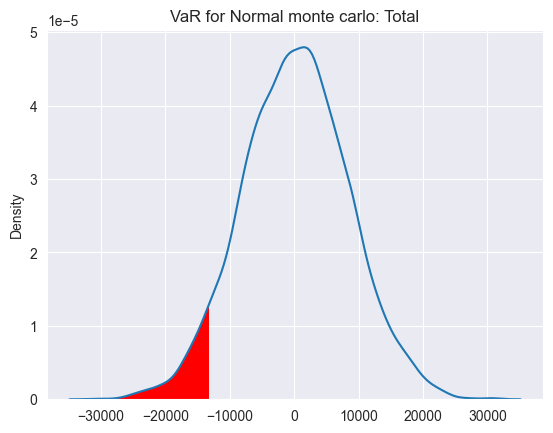

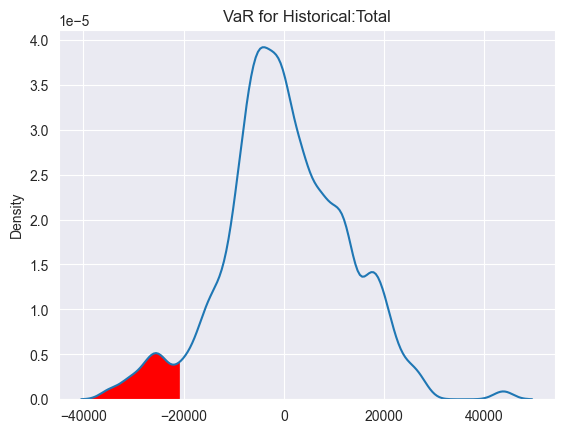

In [36]:
print("VaRs for All:")
var_all_delta = delta_norm('All',price_data,port_data,alpha=0.05)
print("VaR for Delta Normal: {}".format(round(var_all_delta,2)))
var_all_mc = return_sim_mc('All',price_data,port_data,nsim=10000,alpha=0.05)
print("VaR for Normal monte carlo: {}".format(round(var_all_mc[0],2)))
var_all_his = return_sim_his('All',price_data,port_data,nsim=10000,alpha=0.05)
print("VaR for Historical: {}".format(round(var_all_his[0],2)))
plot_var(var_all_mc[1],var_all_mc[0],"VaR for Normal monte carlo: Total")
plot_var(var_all_his[1],var_all_his[0],"VaR for Historical:Total")